# DATA 620 Final Project

### Text Mining and Gene Network Analysis with Non-small Cell Lung Cancer

### Youqing Xiang

In [1]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## Introducation

In this project, I integrate text mining and network analysis for informative discoveries in Non-small cell lung cancer (NSCLC) area. From Pubmed, I mined 4483 of abstracts, which are relevant to the topic of NSCLC. And then I extract co-occurrences of genes and build the network of gene-gene interaction. By analyzing the gene network, I look for those important molecular markers relate to NSCLC.

## Process Text Data

### Load the data

Extracting 4483 abstracts from Pubmed was done in R by taking advantage of R package RISmed. And I also did basic data cleaning in R and saved all the abstract as *nsclc.csv* file.

In [2]:
df = pd.read_csv('Data/nsclc.csv')

In [3]:
df = df[['Title','Abstract']]
df = df.dropna()
df = df.reset_index()
n = len(df)
n

4483

In [4]:
# show one abstract
abs1 = df['Abstract'][0]
abs1

"Current chemotherapeutic regimens for nonsmall cell lung cancer (NSCLC) have reached a plateau over the last few years. Targeted therapy makes use of tyrosine kinase inhibitors (TKIs) to suppress a number of signaling pathways including epidermal growth factor receptor and vascular endothelial growth factor which are active in NSCLC biology. In this study, we used sunitinib, a multi-target receptor TKI, combined with chemotherapy for unresectable/metastatic NSCLC.This open label Simon's 2 stage clinical trial enrolled a total of 6 NSCLC patients who received docetaxel (40\xe2\x80\x8amg) and cisplatin (50\xe2\x80\x8amg) on day 1 of each cycle (14 day interval between cycles) and sunitinib (25\xe2\x80\x8amg qd for 10 days between cycles) for a total of 12 cycles (24 weeks), after which patients received maintenance therapy with vinorelbine (30\xe2\x80\x8amg TIW) until disease progression. The sample size was based on a Simon's Optimal Two-Stage Designs for Phase II clinical trials. The 

### Extract Genes

Human gene symbols generally are italicised, with all letters in uppercase (e.g., SHH, for sonic hedgehog). Italics are not necessary in gene catalogs. Protein designations are the same as the gene symbol, but are not italicised, with all letters in uppercase (SHH).

* https://en.wikipedia.org/wiki/Gene_nomenclature

Please note that all genes showing in abstracts are not italicised.

In [5]:
style = '^[A-Z]{1,}.*[A-Z0-9]$'

In [6]:
genes = []
n = len(df)
for i in range(n):
    abstract = df['Abstract'][i]
    abstract = abstract.replace('.',' ').replace(',',' ').replace("'",' ').replace("(",' ')
    abstract = abstract.replace('?',' ').replace(")",' ').replace('+', ' ').replace('=',' ')
    abstract = abstract.replace('/',' ').replace(':',' ').replace(';',' ')
    abstract = abstract.encode('string_escape').replace('\\\\','\\')
    abstract = abstract.replace("\\",' ')
    words = abstract.split(' ')
    
    for word in words:
        m = re.match(style,word)
        if m:
            gene = m.group(0)
            if gene not in genes:
                genes.append(gene)

In [7]:
len(genes)

6239

In [8]:
genes[0:5]

['NSCLC', 'TKI', 'TIW', 'II', 'P0']

Among 6239 of names, most of them are actually not genes. So, I need to continue cleaning.

### Load human genes database

* http://biomart.genenames.org

In [10]:
human_genes = pd.read_csv('Data/human_genes.csv')

In [11]:
human_genes = human_genes[['HGNC.ID','Approved.symbol']]
human_genes.head()

,HGNC.ID,Approved.symbol
0,HGNC:5,A1BG
1,HGNC:37133,A1BG-AS1
2,HGNC:24086,A1CF
3,HGNC:7,A2M
4,HGNC:27057,A2M-AS1


In [12]:
human_genes = human_genes['Approved.symbol']
len(human_genes)

41343

In [13]:
human_genes[0:4]

0        A1BG
1    A1BG-AS1
2        A1CF
3         A2M
Name: Approved.symbol, dtype: object

### Get the list of NSCLC genes

In [14]:
nsclc_genes = set(human_genes) & set(genes)

In [15]:
len(nsclc_genes)

1194

Now, I have 1194 of genes. These 1194 names are the symbol of genes, but they could also have different means in actual abstract.

### Clicial Terminology

In [16]:
ct_list = ['ABO','HR','ED', 'PC', 'FAP','IV','PET','DCR','VATS','RBI','SBRT','RT','ICB','CS']

In [17]:
nsclc_genes = set(nsclc_genes) - set(ct_list)
len(nsclc_genes)

1186

It is very difficult to telll what the actual meaning of extracted names are in abstract until I read through the whole abstract. This is the issue I need to keep in mind.

### Extract genes from each abstract

In [18]:
def extract_genes(abstract):
    genes = []
    style = '^[A-Z]{1,}.*[A-Z0-9]$'
    abstract = abstract.replace('.',' ').replace(',',' ').replace("'",' ').replace("(",' ')
    abstract = abstract.replace('?',' ').replace(")",' ').replace('+', ' ').replace('=',' ')
    abstract = abstract.replace('/',' ').replace(':',' ').replace(';',' ')
    abstract = abstract.encode('string_escape').replace('\\\\','\\')
    abstract = abstract.replace("\\",' ')
    words = abstract.split(' ')
    for word in words:
        m = re.match(style,word)
        if m:
            gene = m.group(0)
            if gene not in genes:
                genes.append(gene)
                
    genes = set(nsclc_genes) & set(genes)
    genes = list(genes)
    return genes

In [19]:
genes_list = []
n = len(df)
for i in range(n):
    abstract = df['Abstract'][i]
    genes = extract_genes(abstract)
    if len(genes) > 1:
        genes_list.append(genes)

In [20]:
len(genes_list)

774

In [21]:
genes_list[3]

['EGFR', 'KRAS']

## Draw network

In [22]:
d_gen = {}

for y in genes_list:
    y = [(y1,y2) for y1 in y for y2 in y if y1 != y2]
    for link in y:
        if link not in d_gen.keys():
            d_gen[link] = 1
        else:
            d_gen[link] += 1

In [23]:
gen_net = [(a,b,d_gen[a,b]) for (a,b) in d_gen.keys()]

In [24]:
G = nx.Graph()
G.add_weighted_edges_from(gen_net)

In [25]:
weights = [edata['weight'] for f,t,edata in G.edges(data=True)]

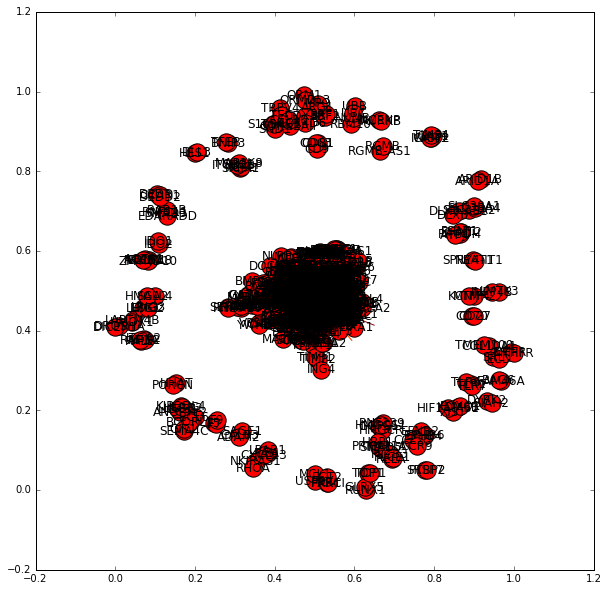

In [26]:
plt.figure(figsize=(10,10))
nx.draw_networkx(G, width=weights, edge_color=weights)
plt.savefig('nsclc_genes.png')
plt.show()

## Network Analysis

Here I chose the biggest component to study.

In [27]:
imp_genes = nx.connected_component_subgraphs(G).next()

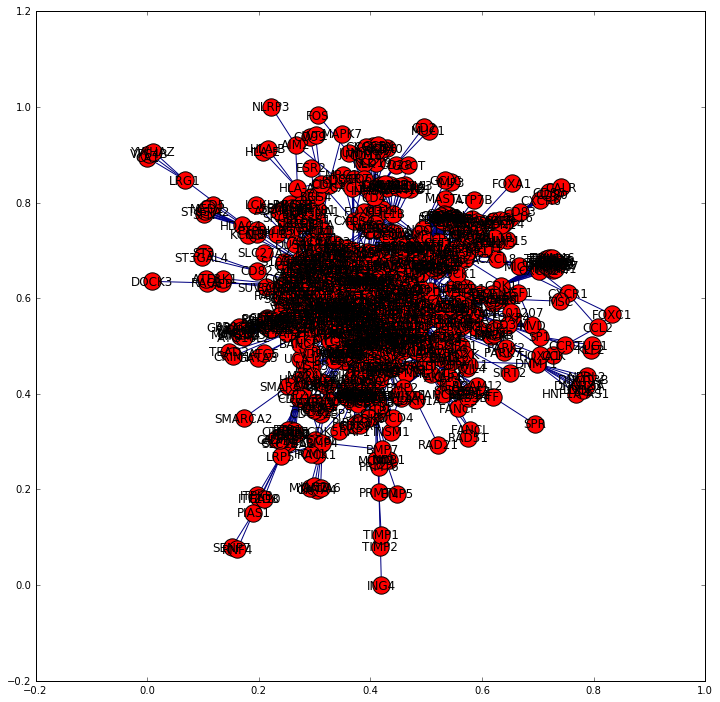

In [28]:
weights = [edata['weight'] for f,t,edata in imp_genes.edges(data=True)]
plt.figure(figsize = (12,12))
nx.draw_networkx(imp_genes, width=weights, edge_color=weights)
plt.show()

### Basic analysis on network

In [29]:
print("The number of node: %d" % imp_genes.number_of_nodes())
print("Radius: %d" % nx.radius(imp_genes))
print("Diameter: %d" % nx.diameter(imp_genes))
print("Density: %s" % nx.density(imp_genes))

The number of node: 749
Radius: 5
Diameter: 10
Density: 0.0114484196397


### Calculate degree centrality and eigenvector centrality

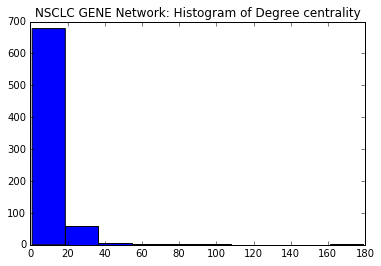

In [30]:
deg = nx.degree(imp_genes)
plt.hist(deg.values())
plt.title('NSCLC GENE Network: Histogram of Degree centrality')
plt.show()

In [31]:
def sorted_map(map):
    ms = sorted(map.iteritems(),key=lambda(k,v):(-v,k))
    return ms

In [32]:
sorted_map(deg)[0:5]

[('EGFR', 179), ('KRAS', 93), ('TP53', 78), ('ALK', 70), ('PIK3CA', 57)]

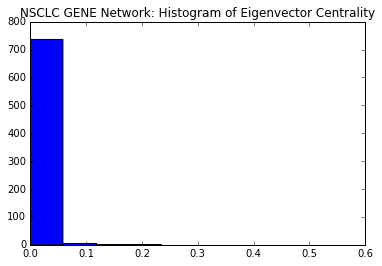

In [33]:
e = nx.eigenvector_centrality(imp_genes)
plt.hist(e.values())
plt.title('NSCLC GENE Network: Histogram of Eigenvector Centrality')
plt.show()

In [34]:
sorted_map(e)[0:5]

[('EGFR', 0.5840183638789822),
 ('ALK', 0.4926852332900447),
 ('KRAS', 0.42785372090324797),
 ('BRAF', 0.23452144648448417),
 ('ROS1', 0.2324531050335987)]

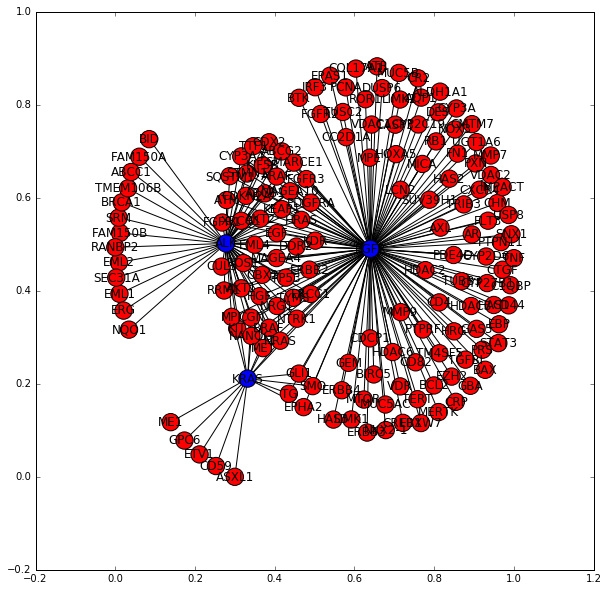

In [35]:
sub_centers = ['EGFR', 'KRAS','ALK']
sub = nx.Graph([(k,v) for k,v in imp_genes.edges() if k in sub_centers])
node_colors = ['b' if n in sub_centers else 'r' for n in sub.nodes()]
pos = nx.spring_layout(sub)
plt.figure(figsize=(10,10))
nx.draw_networkx(sub, node_color=node_colors,with_labels=True)
plt.show()

From the network centrality anlysis, I can see that EGFR is the most important gene. And ALK is also very important.

### Applying for  Island Method to NSCLC GENE Network

In [36]:
# function from the textbook
def trim_edges(g, weight=1): 
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

In [37]:
# function from the textbook
def island_method(g, iterations=5):
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn = int(min(weights))
    mx = int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [38]:
islands = island_method(imp_genes)
for i in islands:
    print i[0], len(i[1])

1 119
24 7
47 3
70 3
93 3
116 2


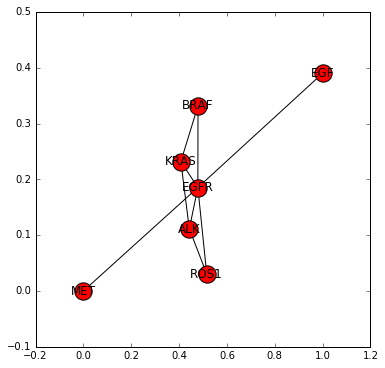

In [39]:
imp_genes_2 = trim_edges(imp_genes, 24)
weights = [edata['weight'] for f,t,edata in imp_genes_2.edges(data=True)]
plt.figure(figsize=(6, 6))
#nx.draw_networkx(imp_genes_2, width=weights, edge_color=weights)
nx.draw_networkx(imp_genes_2)
plt.show()

EGFR, KRAS, ALK, MET, ROS1, BRAF mutations are found in NSCLC. These 'driver' mutations lead to constitutive activation of mutant signaling proteins that induce and sustain tumorigenesis. EGF binds to EGFR and induces the downstream reactions.

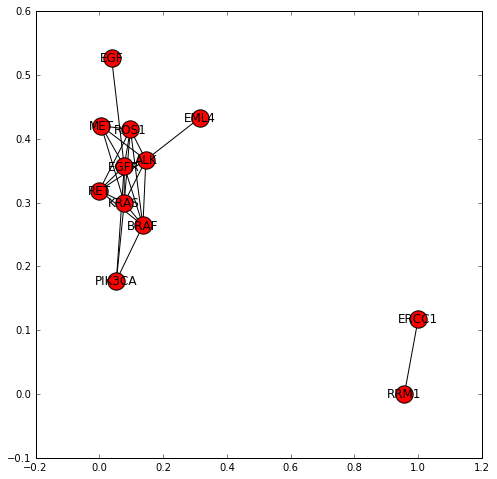

In [40]:
imp_genes_3 = trim_edges(imp_genes,10)
weights = [edata['weight'] for f,t,edata in imp_genes_3.edges(data=True)]
plt.figure(figsize=(8, 8))
#nx.draw_networkx(imp_genes_2, width=weights, edge_color=weights)
nx.draw_networkx(imp_genes_3)
plt.show()

ERCC1 and RRM1 expression levels have been explored as markers of DNA repair capacity in tumor cells. And low leverl ERCC1 and/or RRM1 expression is associated with sensitivity to platinum, a classic chemotherapy drugs.

EGFR, AlK and other gene mutations can be targeted by small molecule or antibodies, which are called targeted therapy drugs.

So, these two network islands are different in terms of association mechanism with NSCLC.

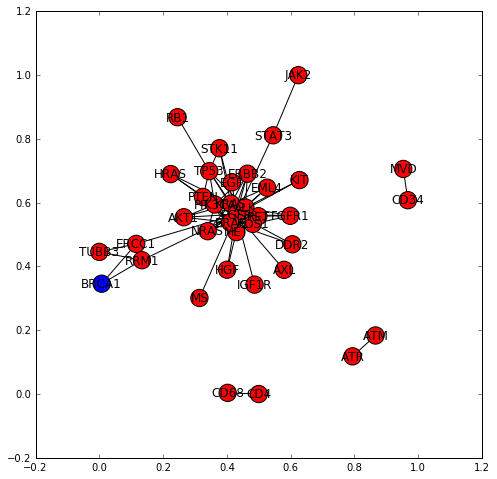

In [41]:
imp_genes_4 = trim_edges(imp_genes,3)
weights = [edata['weight'] for f,t,edata in imp_genes_4.edges(data=True)]
plt.figure(figsize=(8, 8))
#nx.draw_networkx(imp_genes_2, width=weights, edge_color=weights)
sub_centers = ['BRCA1']
node_colors = ['b' if n in sub_centers else 'r' for n in imp_genes_4.nodes()]
#nx.draw_networkx(sub, node_color=node_colors,with_labels=True)
nx.draw_networkx(imp_genes_4, node_color=node_colors)
plt.show()

BRCA1 is a breast and ovarian caner gene. Why BRCA1 here?

Research papers showed that BRCA1 mRNA expression is in response to DNA damaging chemotherapy.

## Discussion

+ From the above network analysis results, I can see that this project was able to catch the overall research trend of NSCLC study, which is very promising.

+ It would take more time and deeper study to search for potentially new interesting genes or potential research project ideas. In this project, I didn't get that far.

+ I need to continue to improve the gene extracting method and make sure that all the genes showing up at abstracts are extracted.

+ Please note that all the abstracts were published between 2014 and 2015.

+ From the project, I can see that integrating text mining and network analysis is a useful way for informatics research.